# Pump it Up: Tanzania Water Wells

**Authors:** Kevin McDonough, Ryan Reilly

![title](images/HappyKid_well.jpeg)

## Overview

This project analyzes data for over 74,000 water wells that have been installed in Tanzania over the years. The goal of this analysis is to determine what features of a water well provide a good prediction if the well is functional, not functional, or functional but needs repair. This will be done through exploratory data analysis and iterative predictive modeling using classification models. 

## Business Problem

The Tanzania Ministry of Water have hired us to predict the operating condition for wells in their country. They will use our analysis to send teams of people out to fix the waterpoints that are currently not functional or need repair. Based on our analysis, we are going to provide reccomendations based on the following.

- Which wells you should start fixing first based on location
- Which funders and installers to focus on when building new wells
- Which type of wells should be used to replace non-functional wells
- Who should manage the wells

## Data Understanding

Each row in this dataset represents a unique water well in Tanzania and surrounding information about the well. There are a number of columns related to geo location of the well. There is also a good mix of continuous and categorical variables in the dataset. Each feature and its description is listed below.

The below cell allows us to left align the below data dictionary table

In [167]:
%%html
<style>
table {float:left}
</style>

| Feature | Description|
|:-------| :-------|
|amount_tsh| Total static head (amount water available to waterpoint)|
|date_recorded| The date the row was entered|
|funder| Who funded the well|
|gps_height| Altitude of the well|
|installer| Organization that installed the well|
|longitude| GPS coordinate|
|latitude| GPS coordinate|
|wpt_name| Name of the waterpoint if there is one|
|num_private| No info for this column|
|basin| Geographic water basin|
|subvillage| Geographic location|
|region| Geographic location|
|region_code| Geographic location (coded)|
|district_code| Geographic location (coded)|
|lga| Geographic location|
|ward| Geographic location|
|population| Population around the well|
|public_meeting| Whether a public meeting was held in the village about WP management|
|recorded_by| Group entering this row of data|
|scheme_management| Who operates the waterpoint|
|scheme_name| Who operates the waterpoint|
|permit| If the waterpoint is permitted|
|construction_year| Year the waterpoint was constructed|
|extraction_type| The kind of extraction the waterpoint uses|
|extraction_type_group| The kind of extraction the waterpoint uses|
|extraction_type_class| The kind of extraction the waterpoint uses|
|management| How the waterpoint is managed|
|management_group| How the waterpoint is managed|
|payment| What the water costs|
|payment_type| What the water costs|
|water_quality| The quality of the water|
|quality_group| The quality of the water|
|quantity| The quantity of water|
|quantity_group| The quantity of water|
|source| The source of the water|
|source_type| The source of the water|
|source_class| The source of the water|
|waterpoint_type| The kind of waterpoint|
|waterpoint_type_group| The kind of waterpoint|

#### Importing packages and loading the datasets

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy import DummyClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import plot_roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import json

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import time

from IPython.display import display, HTML

#Use the functions in the py file for preprocessing
import sys
sys.path.insert(0, 'src/')
import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the data
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')

# for ED and train/test/split
xy_train = X_train.merge(y_train, on='id', how='inner')

#This was created for a visual in EDA where we did not want to prepocess anything
xy_train2 = xy_train.copy()

#### Get an understanding of the data

In [3]:
#Take a look at the datatypes
X_train.info()
print('---------------------------------------------------')
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

From the info above, it looks like we have 59,400 rows in our training data representing water wells with 39 columns. We will have to decide how we want to treat the columns with nulls which are funder, installer, subvillage, public_meeting, scheme_management, sheme_name, and permit. Most of our data types are objects, so we will need to encode a lot of these variables to for our classification models. There also looks to be a lot of columns that may have the same type of information (ie, waterpoint_type and waterpoint_type_group) so we will explore these value_counts. 

In [4]:
#Take a look at the outcome variable and its value counts
xy_train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

There are three classes. There looks to be a good balance of functional and non functional values, but there is a low sample of functional needs repair. Since this is pretty imbalanced, we may need to implement a resampling techinique to synthitically create more values in this third class. We may use SMOTE when we get to the modeling stage. 

## Data Preparation

### Handle Missing Values

In [168]:
#Create a dataframe with just those columns with NAs and there sums.

missing = pd.DataFrame(xy_train.isna().sum(), columns = ['Nulls'])
missing.index.name = 'Feature'
    
missing.sort_values(by=['Nulls'])[-7:]

,Nulls
Feature,
lga,0
ward,0
population,0
public_meeting,0
scheme_management,0
permit,0
scheme_name,28166


#### funder, installer, subvillage, and scheme_management

In [6]:
columns = xy_train[['funder', 'installer', 'subvillage', 'scheme_management']]

def impute_unknown(data, columns):
    '''Replace NAs with Unknown.'''
    for col in columns:
        data[col].fillna(value='Unknown', inplace=True)

impute_unknown(xy_train, columns)

For the above categorical columns, we decided to replace NAs with 'Unknown'

#### public_meeting and permit

In [7]:
columns = xy_train[['public_meeting', 'permit']]

def impute_false(data, columns):
    '''Replace NAs with False.'''
    for col in columns:
        data[col].fillna(value='False', inplace=True)

impute_false(xy_train, columns)

Both of the above columns were boolean and we decided to replace NAs with the overwhelmingly False value

#### scheme_name

This column had too many NAs (over half of the rows) so we will drop from the dataset.

### Handle Outliers

In [8]:
xy_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


There are a lot of zeros in the min row that dont make sense that we need to take care of. 

#### population, gps_height, latitude, longitude

In [9]:
columns = xy_train[['population', 'gps_height', 'latitude', 'longitude']]

def replace_zeros_mean(data, columns):
    '''Replace zeros with mean of column.'''
    for col in columns:
        data[col].replace(0, data[col].mean(), inplace=True)
        
replace_zeros_mean(xy_train, columns)        

For the above numerical columns, a value of zero does not make sense. Zero is an okay value for gps height, latitude and longitude in general, but based on Tanzanias geo location, this does not make sense.

#### construction_year

In [10]:
columns = xy_train[['construction_year']]

def replace_zeros_median(data, columns):
    '''Replace zeros with mean of column.'''
    for col in columns:
        data[col].replace(0, data[col].median(), inplace=True)
        
replace_zeros_median(xy_train, columns)   

For construction year, we replaced the zeros with the midean of the years, which ended up being 1986. 

#### latitude

In [11]:
xy_train['latitude'].replace(to_replace = -2.000000e-08 , value =np.mean(xy_train['latitude']), inplace=True)

There were latitudes that would place the well north of Tanzania, which does not make sense so we took the mean value.

### Check for row duplicates

In [12]:
print('Number of X_train duplicates: {}'.format(len(xy_train[xy_train.duplicated()])))
print('Number of X_test duplicates: {}'.format(len(X_test[X_test.duplicated()])))

Number of X_train duplicates: 0
Number of X_test duplicates: 0


### Remove columns

#### Check value counts of categorical variables to see if information is the same between columns

The below cell allows us to view the value counts for similer columns side by side within a cell.

#### quntity_group vs quantity

The below cell allows us to view the tables side by side. 

In [13]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [14]:
q1 = xy_train['quantity_group'].value_counts().to_frame()
q2 = xy_train['quantity'].value_counts().to_frame()
display(q1)
display(q2)

,quantity_group
enough,33186
insufficient,15129
dry,6246
seasonal,4050
unknown,789


,quantity
enough,33186
insufficient,15129
dry,6246
seasonal,4050
unknown,789


#### source vs source_type

In [15]:
s1 = xy_train['source'].value_counts().to_frame()
s2 = xy_train['source_type'].value_counts().to_frame()
display(s1)
display(s2)

,source
spring,17021
shallow well,16824
machine dbh,11075
river,9612
rainwater harvesting,2295
hand dtw,874
lake,765
dam,656
other,212
unknown,66


,source_type
spring,17021
shallow well,16824
borehole,11949
river/lake,10377
rainwater harvesting,2295
dam,656
other,278


#### payment_type vs payment

In [16]:
p1 = xy_train['payment_type'].value_counts().to_frame()
p2 = xy_train['payment'].value_counts().to_frame()
display(p1)
display(p2)

,payment_type
never pay,25348
per bucket,8985
monthly,8300
unknown,8157
on failure,3914
annually,3642
other,1054


,payment
never pay,25348
pay per bucket,8985
pay monthly,8300
unknown,8157
pay when scheme fails,3914
pay annually,3642
other,1054


#### waterpoint_type_group vs waterpoint_type

In [17]:
w1 = xy_train['waterpoint_type_group'].value_counts().to_frame()
w2 = xy_train['waterpoint_type'].value_counts().to_frame()
display(w1)
display(w2)

,waterpoint_type_group
communal standpipe,34625
hand pump,17488
other,6380
improved spring,784
cattle trough,116
dam,7


,waterpoint_type
communal standpipe,28522
hand pump,17488
other,6380
communal standpipe multiple,6103
improved spring,784
cattle trough,116
dam,7


#### extraction_type_group vs extraction_type vs extraction_type_class

In [18]:
e1 = xy_train['extraction_type_group'].value_counts().to_frame()
e2 = xy_train['extraction_type'].value_counts().to_frame()
e3 = xy_train['extraction_type_class'].value_counts().to_frame()
display(e1)
display(e2)
display(e3)

,extraction_type_group
gravity,26780
nira/tanira,8154
other,6430
submersible,6179
swn 80,3670
mono,2865
india mark ii,2400
afridev,1770
rope pump,451
other handpump,364


,extraction_type
gravity,26780
nira/tanira,8154
other,6430
submersible,4764
swn 80,3670
mono,2865
india mark ii,2400
afridev,1770
ksb,1415
other - rope pump,451


,extraction_type_class
gravity,26780
handpump,16456
other,6430
submersible,6179
motorpump,2987
rope pump,451
wind-powered,117


A lot of the categorical columns we compared above have a lot of the same values in both tables so we will be dropping one of them. 

### Check other columns with significant amount of zeros

#### amount_tsh and num_private

In [19]:
print('Total amount_tsh zeros: {}'.format(xy_train['amount_tsh'].isin([0]).sum()))
print('Total num_private zeros: {}'.format(xy_train['num_private'].isin([0]).sum()))

Total amount_tsh zeros: 41639
Total num_private zeros: 58643


In [20]:
xy_train.drop(['id','amount_tsh', 'num_private', 'region_code', 'quantity_group', 
              'source_type', 'payment_type', 'waterpoint_type_group', 
              'extraction_type_group', 'extraction_type_class','recorded_by'], 
               axis = 'columns', inplace=True)

#### Below are the reasons for removal based on the above analysis:

**id** is not a useful predictor

**amount_tsh** is ~70% zeros

**num_private** is ~99% zeros

**region_code** is the same as region but we will keep region

**quantity_group** has the same values and value counts as quantity

**source_type** has roughly the same categories as source, but source has the categories broken out better (river and lake are seperated in source)

**payment_type** has the same values and value counts as payment

**waterpoint_type_group** has the same values and value counts as waterpoint_type

**extraction_type_group** has roughly the same categories as extraction_type, but extraction_type has the categories broken out better

**extraction_type_class** has even even less catagories than extraction_type_group

**recorded_by** has just one value, "GeoData Consultants Ltd", so it would not be useful in EDA or prediction.

# Feature Engineering

#### Create Month and Year columns

In [21]:
#Convert the date_recorded to datetime column
xy_train['date_recorded'] = pd.to_datetime(xy_train['date_recorded'])

In [22]:
#Create the month and month number column from the date column
xy_train['month_recorded'] = xy_train['date_recorded'].dt.month_name()
xy_train['month_num_recorded'] = xy_train['date_recorded'].dt.month

In [23]:
#Create the year recorded from date column
xy_train['year_recorded'] = xy_train['date_recorded'].dt.year

#### Create Age column

In [33]:
xy_train['age'] = xy_train['year_recorded'].max() - xy_train['construction_year']

#### Create a binned age column to be treated as a categorical 

In [44]:
def bin_age(age):
    '''Create bins using if else'''
    if age > 50:
        return "Unknown"
    elif age >= 0 and age <10:
        return "<10 Years"
    elif age >= 10 and age <20:
        return "10-20 Years"
    elif age >= 20 and age <30:
        return "20-30 Years"
    elif age >= 30 and age <40:
        return "30-40 Years"
    elif age >= 40 and age <50:
        return "40-50 Years"
    elif age >= 50 and age <60:
        return "50-60 Years"
    else:
        return "60+ years"

#Create the column using the function
xy_train['bin_age'] = xy_train['age'].apply(bin_age)

#### Create a binned Installer column

In [77]:
#This is created using groupby so we can pass into the function we create
xy_train['installer_count'] = xy_train.groupby('installer')['year_recorded'].transform(lambda grp: len(grp))

In [81]:
def bin_installer(installer_count):
    '''Create bins using if else'''
    if installer_count > 2000:
        return ">2000"
    elif installer_count >= 500 and installer_count <2000:
        return "500-2000"
    elif installer_count >= 100 and installer_count <500:
        return "100-500"
    else:
        return "<100"
    
#Create the column
xy_train['bin_installer_count'] = xy_train['installer_count'].apply(bin_installer)

# Exploratory Data Analysis

#### What are the classes for the outcome ?

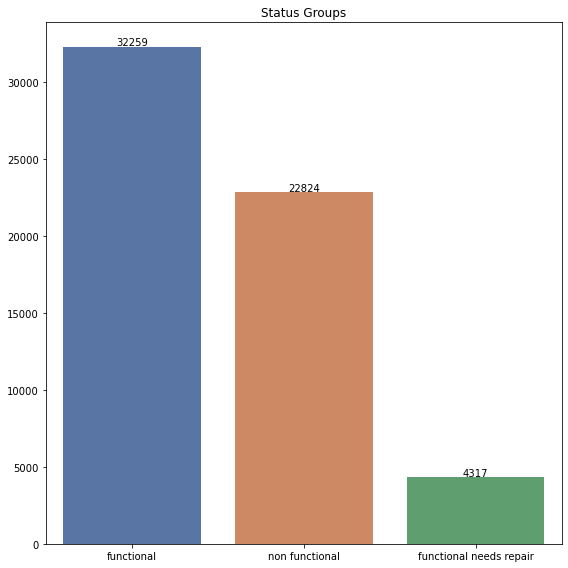

In [61]:
fig2, ax = plt.subplots(figsize = (8,8))

#Create x and y
x = y_train['status_group'].value_counts().index
y = y_train['status_group'].value_counts().values

#Plot the barchart
ax = sns.barplot(x,y,palette='deep')

#ax.set_xlabel("Status Group")
ax.set_title('Status Groups')

plt.ticklabel_format(style = 'plain', axis = 'y')

#This loop allows for lables on the bars
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height+100, # y-coordinate position of data label, padded 100 above bar
 s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
 ha = 'center') # sets horizontal alignment (ha) to center
    
plt.tight_layout()
#fig.savefig('images/sales_per_waterfront.png');

We have a good mix of functional and non-functional wells in our dataset, but not as many wells that are functional and need repair. Like we mentioned above, we will need to use a sampling strategy when we get to the modeling stage. 

#### Do certain types of water quality associate with each status group of the well?

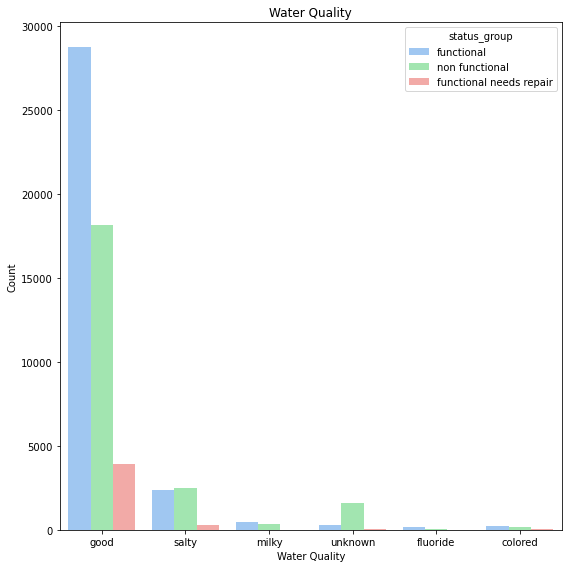

In [171]:
fig, ax = plt.subplots(figsize = (8,8))

no_good = xy_train[xy_train['quality_group'] != 'good']

#Create the plot
ax = sns.countplot(x="quality_group", hue="status_group", data=xy_train)

ax.set_xlabel("Water Quality")
plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_ylabel("Count");
ax.set_title("Water Quality")

plt.tight_layout()
#fig.savefig('images/sales_per_waterfront.png');

The above chart shows that most wells are good quality, but we dont think water quality can tell us much about which wells are functional or not. Each water quality type has a good amount of functional and non-functional.

#### Who were the top installers of water wells?

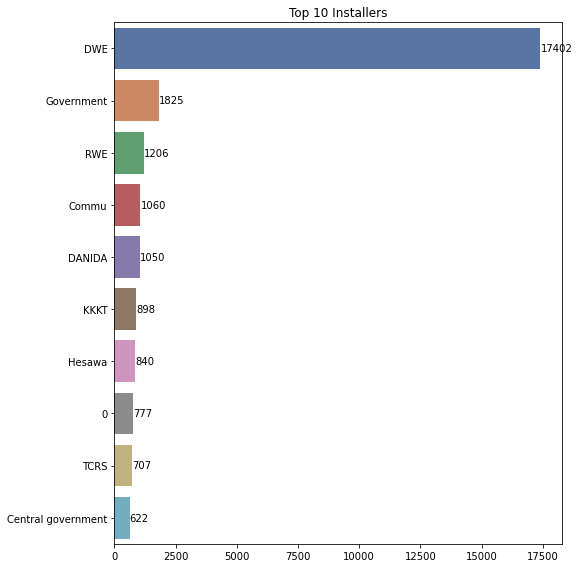

In [62]:
fig2, ax = plt.subplots(figsize = (8,8))

y = X_train['installer'].value_counts().index[:10]
x = X_train['installer'].value_counts().values[:10]

#Create chart
ax = sns.barplot(x,y,palette='deep', orient='h')

ax.set_title('Top 10 Installers')


plt.tight_layout()

#This loop allows for lables on the bars
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
 # adding text to each bar
    ax.text(x = width+3, # x-coordinate position of data label, padded 3 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
    va = 'center') # sets vertical alignment (va) to center
    
    
    
#fig.savefig('images/sales_per_waterfront.png');

DWE looks to have installed most of the wells, followed by the Government and RWE.

#### Are there certain Tiers of installers that tend to make more functional wells?

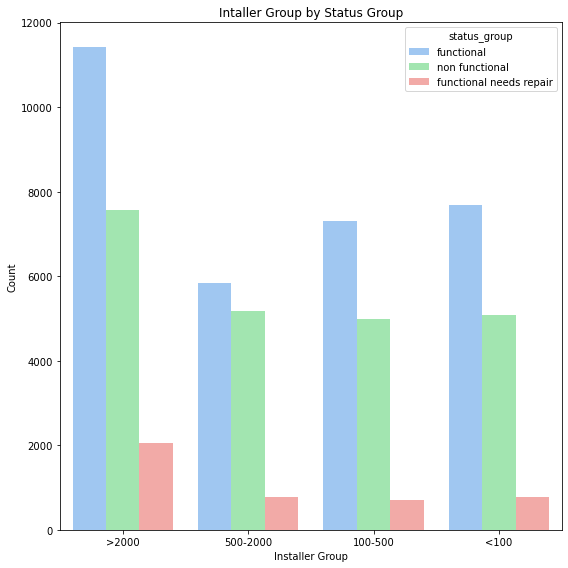

In [88]:
fig, ax = plt.subplots(figsize = (8,8))

#x_cols is created to order the x axis
x_cols = ['>2000', '500-2000', '100-500', '<100']
#Create plot
ax = sns.countplot(x="bin_installer_count", hue="status_group", data=xy_train, order = x_cols)
ax.set_xlabel("Installer Group")
plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_ylabel("Count");
ax.set_title("Intaller Group by Status Group")

plt.tight_layout();

#fig.savefig('images/sales_per_waterfront.png');

It looks like those installers that have a lot of experience intalling wells(those > 2000 installs) have a good proportion of functional and non-functional wells.

#### Are there certain waterpoint types that have more functioning wells

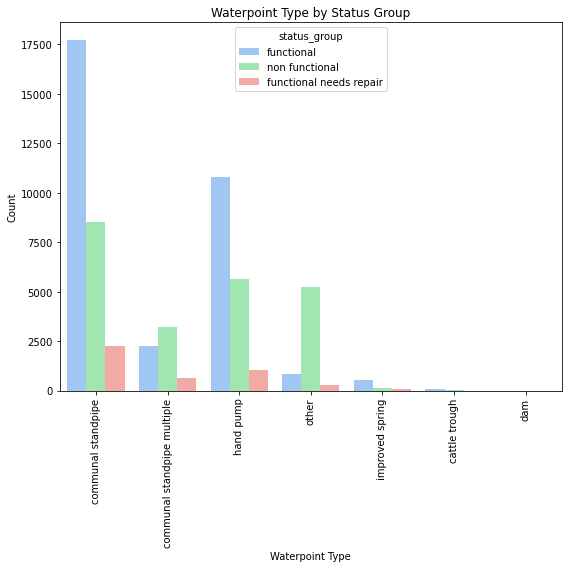

In [162]:
fig, ax = plt.subplots(figsize = (8,8))

#Create plot
ax = sns.countplot(x="waterpoint_type", hue="status_group", data=xy_train)

ax.set_xlabel("Waterpoint Type")
plt.ticklabel_format(style = 'plain', axis = 'y')
ax.set_ylabel("Count")
ax.set_title("Waterpoint Type by Status Group")
ax.tick_params(axis='x', labelrotation = 90)
plt.tight_layout();

#fig.savefig('images/sales_per_waterfront.png');

The standpipe looks to be the most popular waterpoint type, followed by the handpump. It seems if you were going to recommend a waterpoint type for replacement or for a new install you would recommend wither of the two. 

#### Does the age of the well help determine if the well is functional or not? Note: we removed those rows that had a construction year of 0 for the following two charts. 

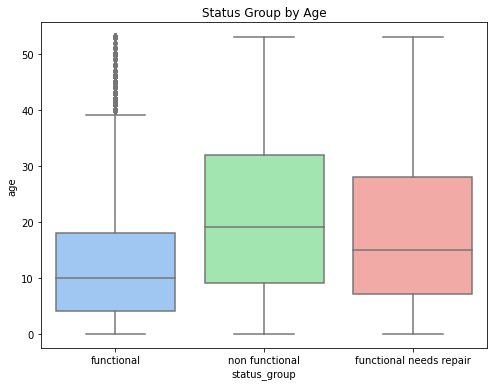

In [164]:
plt.figure(figsize=(8,6))

#Create a new dataset for the chart
data4 = xy_train2[xy_train2['construction_year']!=0]

#Create the chart
sns.boxplot(x='status_group', y='age', data=data4)

plt.title("Status Group by Age");

#fig.savefig('images/sales_per_waterfront.png');

It looks like the average age of functioning wells is considerable lower than non-functioning wells. 

All of the status groups seem to be in the same altitude range, so this does not give us much insight into weather or not the altitude is a good indicator if a well is functional.

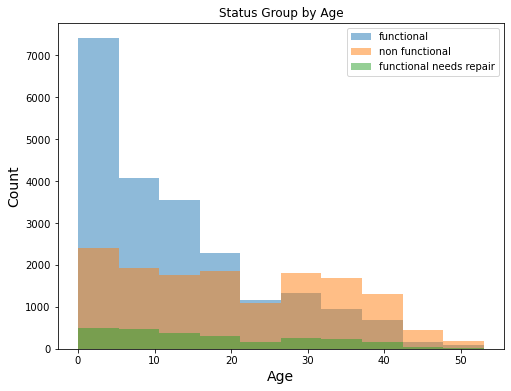

In [43]:
xy_train2['date_recorded'] = pd.to_datetime(xy_train2['date_recorded'])
xy_train2['year_recorded'] = xy_train2['date_recorded'].dt.year
xy_train2['age'] = xy_train2['year_recorded'].max() - xy_train2['construction_year']


data1 = xy_train2[(xy_train2['status_group']=='functional') & (xy_train2['construction_year']!=0)]
data2 = xy_train2[(xy_train2['status_group']=='non functional') & (xy_train2['construction_year']!=0)]
data3 = xy_train2[(xy_train2['status_group']=='functional needs repair') & (xy_train2['construction_year']!=0)]

plt.figure(figsize=(8,6))

plt.hist(data1['age'],alpha=0.5, label="functional")
plt.hist(data2['age'],alpha=0.5, label="non functional")
plt.hist(data3['age'],alpha=0.5, label="functional needs repair")
plt.xlabel("Age", size=14)
plt.ylabel("Count", size=14)
plt.title("Status Group by Age")
plt.legend(loc='upper right');

Above is another look at the distribution of age of the well by each status group. Most wells that are functional less than 20 years old.

#### Does the altitude of the well determine if there are more functioning wells. 

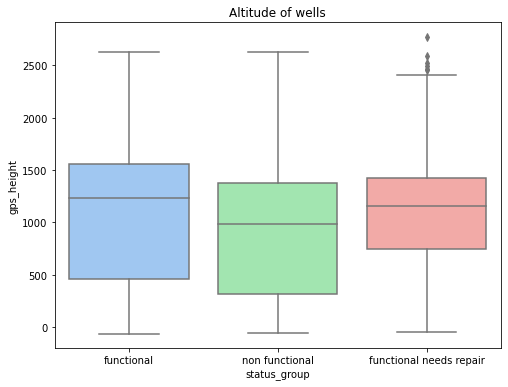

In [172]:
plt.figure(figsize=(8,6))

sns.boxplot(x='status_group', y='gps_height', data=data4)

plt.title("Altitude of wells");

#fig.savefig('images/sales_per_waterfront.png');

All of the status groups seem to be in the same altitude range, so this does not give us much insight into weather or not the altitude is a good indicator if a well is functional.

#### Where are the functional water wells located?

In [ ]:
functional = xy_train[xy_train['status_group'] == 'functional']

#Create the folium map
hmap = folium.Map(location=[functional['latitude'].median(), functional['longitude'].median()], zoom_start=6, )
folium.TileLayer('stamenterrain').add_to(hmap)

#Create locations
locations = functional[['latitude', 'longitude']]
locationlist = locations.values.tolist()

#Create the clusters
marker_cluster = MarkerCluster().add_to(hmap)

#Add the clusters to the map
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
hmap

There seems to be a fairly even distribution of functioning water wells throughout the whole country. 

#### Where are the non-functional water wells located?

In [ ]:
non_functional = xy_train[xy_train['status_group'] == 'non functional']
#Create the folium map
hmap = folium.Map(location=[non_functional['latitude'].median(), non_functional['longitude'].median()], zoom_start=6 )
folium.TileLayer('stamenterrain').add_to(hmap)

#Create locations
locations = non_functional[['latitude', 'longitude']]
locationlist = locations.values.tolist()
#Create the clusters
marker_cluster = MarkerCluster().add_to(hmap)
#Add the clusters to the map
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
hmap

There seems to be a fairly even distribution of non-functioning water wells throughout the whole country. 

#### Where are the functional water wells that need repair located?

In [ ]:
functional_needs_repair = xy_train[xy_train['status_group'] == 'functional needs repair']
#Create the folium map
hmap = folium.Map(location=[functional_needs_repair['latitude'].median(), functional_needs_repair['longitude'].median()], zoom_start=6, )
folium.TileLayer('stamenterrain').add_to(hmap)

#Create locations
locations = functional_needs_repair[['latitude', 'longitude']]
locationlist = locations.values.tolist()
#Create the clusters
marker_cluster = MarkerCluster().add_to(hmap)
#Add the clusters to the map
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster);
hmap

There seems to be a fairly even distribution of functioning water wells that need repair throughout the whole country. 

# Train test split

public_meeting and permit need to be included in the numeric features. They are boolean and need to be converted to ints. They will not work in categorical features as booleans. We convert them in this next cell.

In [45]:
xy_train['public_meeting'] = (xy_train['public_meeting'] == 'TRUE').astype(int)
xy_train['permit'] = (xy_train['permit'] == 'TRUE').astype(int)

In [46]:
#for train_test split
X = xy_train.drop(columns = 'status_group', axis=1)
y = xy_train['status_group']

#Since we dont have y_test, we need to create it here doing a split off of the x and y train.
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size = .2, random_state=42)

# Modeling

### Dummy Model

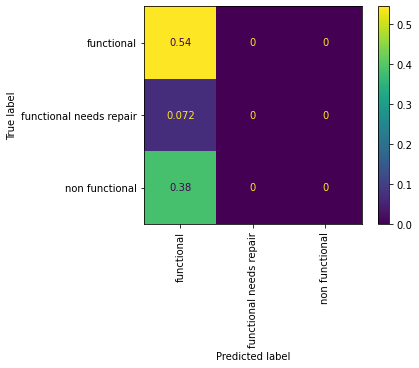

In [47]:
mpl.style.use('seaborn-pastel')
plot_confusion_matrix(DummyClassifier(strategy="most_frequent").fit(X_t, y_t), X_v, y_v, xticks_rotation='vertical', normalize = 'all');

This dummy model is set up to see how well we would do if we just guessed the most common outcome (functional) everytime. We coverted the numbers to percentages in the consfusion matrix so you can see by the top left box that we would only be correct 54% of the time if we did this approach, which is only slightly better than randomly guessing

### Baseline Models with no hyperparameters

Create numerical columns to pass into numerical pipelines. There are two cells, one for the training data and one for the validation data

In [48]:
#Isolate numerical columns for train data
numericals = X_t.select_dtypes(include=['int64', 'float64'])

#convert all numericals to float using loop
X_t_nums = numericals

for col in X_t_nums:
    X_t_nums[col] = X_t_nums[col].astype('float64')

In [49]:
#Isolate numerical columns for validation data
numericals = X_v.select_dtypes(include=['int64', 'float64'])

#convert all numericals to float using loop
X_v_nums = numericals

for col in X_v_nums:
    X_v_nums[col] = X_v_nums[col].astype('float64')

Create  categorical columns to pass into  categorical pipeline. There are two cells, one for the training data and one for the validation data

In [50]:
#Isolate categorical columns for training data
categoricals = X_t.select_dtypes(include= 'object')

#Further isolate specific columns to be used
X_t_cat = categoricals[['region','management','payment','water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'bin_age']]

#convert all categoricals to string using loop
for col in X_t_cat:
    X_t_cat[col] = X_t_cat[col].astype('str')

In [51]:
#Isolate categorical columns for validation data
categoricals = X_v.select_dtypes(include= 'object')

#Further isolate specific columns to be used
X_v_cat = categoricals[['region','management','payment','water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'bin_age']]

#convert all categoricals to string using loop
for col in X_t_cat:
    X_v_cat[col] = X_v_cat[col].astype('str')

Create the numerical and categorical pipelines to pass into the trans pipeline so we can transform all the test data

In [52]:
#Create numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
 #Create categorical pipeline               
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          drop='first',
                          sparse=False))
])
#Pass the pipelines into ColumnTransformer on the training data
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_t_nums.columns),
    ('categorical', categorical_pipeline, X_t_cat.columns)
])

Transform all the validation data

In [53]:
trans_v = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_v_nums.columns),
    ('categorical', categorical_pipeline, X_v_cat.columns)
])

Create a pipline for each model without speicfying hyperparameters

In [54]:
base_pipe_lr = Pipeline([('trans', trans),
                    ('LR', LogisticRegression(random_state=42))])

base_pipe_dt = Pipeline([('trans', trans),
                    ('DT', DecisionTreeClassifier(random_state=42))])

base_pipe_rf = Pipeline([('trans', trans),
                    ('RF', RandomForestClassifier(random_state=42))])

base_pipe_knn = Pipeline([('trans', trans),
                    ('KNN', KNeighborsClassifier())])

base_pipe_svm = Pipeline([('trans', trans),
                     ('SVM', svm.SVC(random_state=42))])

base_pipe_xgb = Pipeline([('trans', trans),
                     ('XGB', XGBClassifier(random_state=42))])

Create a list of pipelines to fit and score.

In [55]:
base_pipes = [base_pipe_lr, base_pipe_dt, base_pipe_rf, base_pipe_knn, base_pipe_svm, base_pipe_xgb] 

Loop through the pipelines and fit using training data.

In [56]:
start = time.time()

for pipe in base_pipes:
    pipe.fit(X_t,y_t)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(end-start))

Time it took to run the fittings: 177.24123215675354


The above took 170 seconds, or roughly 3 minutes, to fit all the models

Create a dictionary of pipelines so we can print out all the scores. 

In [57]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}

Print the accuracy score of each of the models. 

In [58]:
for i, model in enumerate(base_pipes):
    print('{} Testing Accuracy: {}'.format(grid_dict[i], model.score(X_v,y_v)))

Logistic Regression Testing Accuracy: 0.7285353535353535
Decision Trees Testing Accuracy: 0.7507575757575757
Random Forest Testing Accuracy: 0.7901515151515152
K-Nearest Neighbors Testing Accuracy: 0.7625420875420875
Support Vector Machines Testing Accuracy: 0.7624579124579125
XGBoost Testing Accuracy: 0.7938552188552188


All of the models did a pretty good job. It looks like Random Forests and XGBoost were lot better than the rest. We are going to move one step further tune both of these models to see if we can improve our scores. But first, see the below confusion matrices for random forest and XGBoost.

#### Random Forest Confusion Matrix

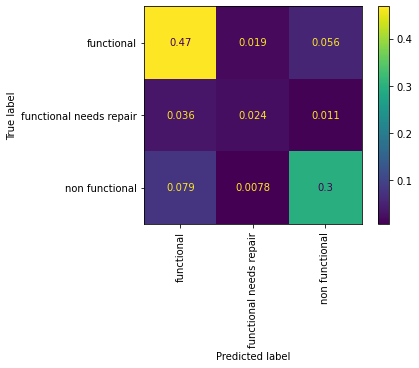

In [89]:
mpl.style.use('seaborn-pastel')
plot_confusion_matrix(base_pipe_rf, X_v, y_v, xticks_rotation='vertical', normalize='all');

The random forest base model did a good job of predicting functional and non-functional but had a hard time predicting the third class, functional needs repair. 

#### XGBoost Confusion Matrix

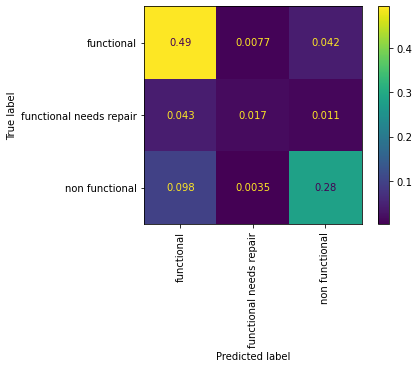

In [90]:
mpl.style.use('seaborn-pastel')
plot_confusion_matrix(base_pipe_xgb, X_v, y_v, xticks_rotation='vertical', normalize='all');

The XGBoost base model did a good job of predicting functional and non-functional but had a hard time predicting the third class, functional needs repair. 

# Hyperparamter Tuning and SMOTE for Random Forest and XGBoost

First we create the two pipelines below that will transform, resample and fit our data.

In [91]:
hyper_pipe_rf = imbPipeline([('trans', trans),
                    ('smote', SMOTE(random_state=42)),
                    ('RF', RandomForestClassifier(random_state=42))])

hyper_pipe_xgb = imbPipeline([('trans', trans),
                     ('smote', SMOTE(random_state=42)),
                     ('XGB', XGBClassifier(random_state=42))])

We then create a paramater grid for each model with various hyperpareters that we will test. 

In [93]:
#Random Forest hyperparameters
min_samples_split = [4,6,8]
n_estimators = [1000]

#Create grid
rf_param_grid = [{'RF__min_samples_split': min_samples_split,
                   'RF__n_estimators': n_estimators}]

#XGBoost Hyperparameters
learning_rates = [.2,.3]
max_depth_XGB = [6,8]
min_child_weight = [1,5]

#Create grid
xgb_param_grid = [{'XGB__learning_rate': learning_rates,
                    'XGB__max_depth': max_depth_XGB,
                    'XGB__min_child_weight': min_child_weight}] 

Now we call GridSearchCV below and pass in the pipline and the param_grid for each model.

In [94]:
rf_grid_search = GridSearchCV(estimator=hyper_pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=2,
        n_jobs=-1) 

xgb_grid_search = GridSearchCV(estimator=hyper_pipe_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=2,
        n_jobs=-1) 

Create a list of grid searches.

In [95]:
hyper_grids = [rf_grid_search, xgb_grid_search]

Create a dictionary of grid searches.

In [96]:
hyper_grid_dict = {0: 'Random Forest', 1: 'XGBoost'}

Loop through both pipelines and fit them. We have also added the time it took to fit both pipelines. 

In [97]:
start = time.time()

for pipe in hyper_grids:
    pipe.fit(X_t,y_t)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(end-start))

Time it took to run the fittings: 472.8272440433502


The below code will print out the accuracy of each model and the best parameters from the grid search. 

In [99]:
for i, model in enumerate(hyper_grids):
    print('{} Train Accuracy: {}'.format(hyper_grid_dict[i], model.score(X_v,y_v)))
    print('{} Best Params: {}'.format(hyper_grid_dict[i], model.best_params_))

Random Forest Train Accuracy: 0.782070707070707
Random Forest Best Params: {'RF__min_samples_split': 4, 'RF__n_estimators': 1000}
XGBoost Train Accuracy: 0.7743265993265993
XGBoost Best Params: {'XGB__learning_rate': 0.3, 'XGB__max_depth': 8, 'XGB__min_child_weight': 1}


Random Forest had the best accuracy, so we will use the random forest model as our final model.

# Final Model Evaluation

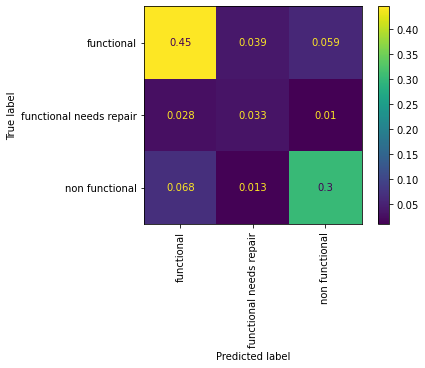

In [102]:
plot_confusion_matrix(rf_grid_search, X_v, y_v, xticks_rotation='vertical', normalize='all');

You can see the final random forest model did a good job of predicting functional and non-functional but still did not do a very good job at predicting functional needs repair even after we implored SMOTE. 

# Submission Predictions

#### Preprocess all of X_test

In [ ]:
columns = X_test[['funder', 'installer', 'subvillage', 'scheme_management']]
impute_unknown(X_test, columns)

In [ ]:
columns = X_test[['public_meeting', 'permit']]
impute_false(X_test, columns)

In [ ]:
columns = X_test[['population', 'gps_height', 'latitude', 'longitude']]
replace_zeros_mean(X_test, columns)

In [ ]:
columns = X_test[['construction_year']]

replace_zeros_median(X_test, columns)

In [ ]:
X_test['latitude'].replace(to_replace = -2.000000e-08 , value =np.mean(X_test['latitude']), inplace=True)

In [ ]:
X_test.drop(['id','amount_tsh', 'num_private', 'region_code', 'quantity_group', 
              'source_type', 'payment_type', 'waterpoint_type_group', 
              'extraction_type_group', 'extraction_type_class','recorded_by'], 
               axis = 'columns', inplace=True)

In [ ]:
#Convert the date_recorded to datetime column
X_test['date_recorded'] = pd.to_datetime(X_test['date_recorded'])

In [ ]:
#Create the month and month number column from the date column
X_test['month_recorded'] = X_test['date_recorded'].dt.month_name()
X_test['month_num_recorded'] = X_test['date_recorded'].dt.month

In [ ]:
#Create the year recorded from date column
X_test['year_recorded'] = X_test['date_recorded'].dt.year

In [ ]:
X_test['age'] = X_test['year_recorded'].max() - X_test['construction_year']

In [ ]:
X_test['bin_age'] = X_test['age'].apply(bin_age)

In [ ]:
X_test['installer_count'] = X_test.groupby('installer')['year_recorded'].transform(lambda grp: len(grp))

In [ ]:
X_test['bin_installer_count'] = X_test['installer_count'].apply(bin_installer)

In [ ]:
X_test['public_meeting'] = (X_test['public_meeting'] == 'TRUE').astype(int)
X_test['permit'] = (X_test['permit'] == 'TRUE').astype(int)

In [ ]:
#Isolate numerical columns for train data
numericals = X_test.select_dtypes(include=['int64', 'float64'])

#convert all numericals to float using loop
X_test_nums = numericals

for col in X_test_nums:
    X_test_nums[col] = X_test_nums[col].astype('float64')

In [ ]:
#Isolate categorical columns for training data
categoricals = X_test.select_dtypes(include= 'object')

#Further isolate specific columns to be used
X_test_cat = categoricals[['region','management','payment','water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'bin_age']]

#convert all categoricals to string using loop
for col in X_test_cat:
    X_test_cat[col] = X_test_cat[col].astype('str')

In [ ]:
#Create numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
 #Create categorical pipeline               
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          drop='first',
                          sparse=False))
])
#Pass the pipelines into ColumnTransformer on the training data
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [ ]:
y_hat = rf_grid_search.predict(X_test)

In [ ]:
#np.savetxt('final_predictions.csv', y_hat, delimiter=',')

# Conclusions

**1. Start fixing wells that are non-functional and located where the counts are the highest .** 

**2. Recommend replalcing non-functional wells with the top installers.**

**3. Consider using this type of well.** 

# Next Steps

Further analyses could provide even more insight into how you will advise your clients to buy or sell thier home. 

**Better idea of features of a home** Other features that indacate home sale include the color of the home, number of windows, garage indicator, size of garage, pool indicator, size of lawn, full property size, flood indicater, style of the home, among others.

**Better idea of neighborhood and surrounding neighborhoods.** We could gather more qualitative data on surrounding neighborhoods such as neighborhood safety, population demographics, and other idicators that may predict the price of a home. You could get an idea of proximity to schools, grocery stores, the city.

**Better idea of surrounding counties in Washington.** We could gather data from other counties and compare, county to county, how sale prices fluctuate. Other macro indicators of county could be political climate, social programs, broader proxiimity to major highways. 

**Better idea of sale history.** We had a fairly good sample of two years worth of data, but it would be good to gather even more years of sales data in King County further solidify reccomendations. There may be features of the home that are better at predicting sale price now then they were 5 or 10 years ago. 